In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

## Считываем данные

In [3]:
prices = pd.read_excel('~/notebooks/summer_school/data/price.xlsx', index_col=0, parse_dates=True)
index = pd.read_excel('~/notebooks/summer_school/data/benchmark.xlsx', index_col=0, parse_dates=True)['CLOSE']

pe = pd.read_excel('~/notebooks/summer_school/data/mults/pe.xlsx', index_col=0, parse_dates=True)
mcap = pd.read_excel('~/notebooks/summer_school/data/financials/market_cap.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('~/notebooks/summer_school/data/liquidity/volume.xlsx', index_col=0, parse_dates=True)

## Создаем на основе данных факторы

In [4]:
# фильтр на основе среднедневного объема
liquidity_filter = pqr.Factor(volume).look_back().data > 2_000_000

# основной фактор на основе P/E
value = pqr.Factor(pe).look_back(3).hold(3)
value.prefilter(liquidity_filter)

# взвешивающий фактор на основе капитализации
size_w = pqr.Factor(mcap).look_back()

# бенчмарк уже готовый
benchmark = pqr.Benchmark('FTSE MIB').from_index(index)

## "Обучаем" факторную модель.

In [5]:
portfolios = pqr.fit_factor_model(
    stock_prices=prices,
    factor=value,
    weighting_factor=size_w,
    fee_rate=0.0005,
    balance=100_000,
    quantiles=3,
    add_wml=True,
    is_bigger_better=False
)

## После обучения у факторной модели появились портфели. С ними можно работать по отдельности

In [6]:
portfolios[0].returns

2016-04-30    0.000000
2016-05-31   -0.069791
2016-06-30   -0.205065
2016-07-31    0.147165
2016-08-31   -0.017629
                ...   
2020-12-31   -0.011313
2021-01-31   -0.036092
2021-02-28    0.160036
2021-03-31    0.110351
2021-04-30   -0.005231
Freq: M, Name: q(0.00, 0.33), Length: 61, dtype: float64

In [7]:
pqr.alpha(portfolios[0].returns, benchmark.returns)

-0.0021876977844496417

In [8]:
pqr.rolling_alpha(portfolios[0].returns, benchmark.returns)

2016-04-30             NaN
2016-05-31             NaN
2016-06-30             NaN
2016-07-31             NaN
2016-08-31             NaN
                  ...     
2020-12-31    8.673617e-18
2021-01-31    3.469447e-18
2021-02-28    1.040834e-17
2021-03-31    2.515349e-17
2021-04-30   -2.493665e-18
Freq: M, Length: 61, dtype: float64

In [9]:
pqr.rolling_sharpe_ratio(portfolios[0].returns)

2016-04-30         NaN
2016-05-31         NaN
2016-06-30         NaN
2016-07-31         NaN
2016-08-31         NaN
                ...   
2020-12-31   -0.315738
2021-01-31   -0.254678
2021-02-28    0.190119
2021-03-31    0.988249
2021-04-30    1.056577
Freq: M, Length: 61, dtype: float64

In [10]:
pqr.max_drawdown(portfolios[0].returns)

-0.5295230794095218

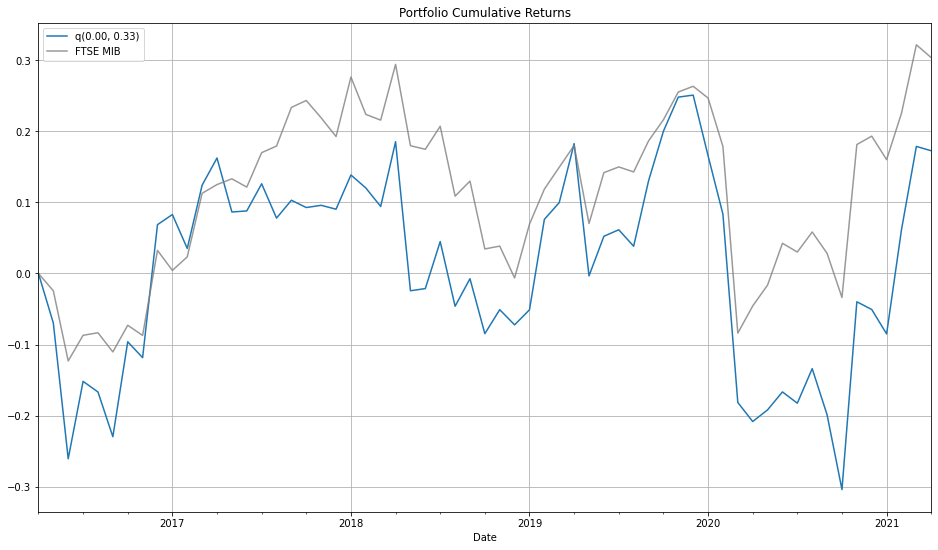

In [11]:
pqr.plot_cumulative_returns([portfolios[0]], benchmark)

## Сравниваем портфели 
tabulate пришлось убрать, поскольку при отрисовке больше 3 портфелей у меня слетало форматирование из-за того, что вывод не помещался. Пока временно сделал табличку с помощью пандаса

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)",wml
"Total Return, %",17.24,42.29,-1.40,-29.49
"Annual Return, %",3.18,7.18,-0.28,-6.64
"Annual Volatility, %",33.94,22.94,24.45,23.94
"Mean Return, %",0.72,0.79,0.22,-0.34
"Win Rate, %",52.46,60.66,50.82,40.98
"Volatility, %",9.80,6.62,7.06,6.91
"Maximum Drawdown, %",-52.95,-39.83,-28.36,-75.97
"VaR, %",-15.73,-10.22,-11.28,-10.24
"Expected Tail Loss, %",-19.59,-12.46,-14.25,-13.65
Rachev Ratio,1.18,1.16,1.07,1.05


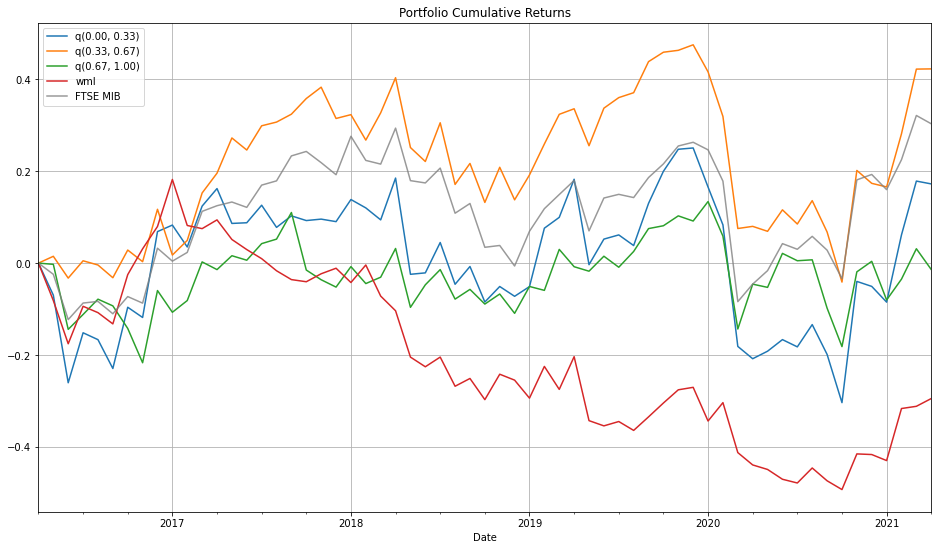

In [12]:
pqr.factor_model_tear_sheet(portfolios, benchmark)

## grid_search
Функция из модуля factor_model - принимает на вход сначала 3 списка/массива/чего угодно, по чему можно итерироваться; дальше все параметры повторяют параметры метода fit(). Возвращает словарь, в котором ключ - кортеж вида (1, 0, 1) - это, соответственно, looking_period, lag_period, holding_period, а значение - датафрейм с результатами (такой же, как и в compare_portfolios()). 

In [13]:
%%time
%%capture

results = pqr.grid_search(
    prices,
    pe,
    looking_back_periods=[1, 3, 6, 9, 12],
    method='static',
    lag_periods=[0, 1],
    holding_periods=[1, 3, 6, 9, 12],
    balance=100_000,
    mask=liquidity_filter,
    weighting_factor=size_w,
    benchmark=benchmark
)

CPU times: user 8.88 s, sys: 3.89 ms, total: 8.89 s
Wall time: 8.88 s


In [14]:
results[(1, 0, 1)]

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)"
"Total Return, %",-7.12,52.10,0.56
"Annual Return, %",-1.40,8.32,0.11
"Annual Volatility, %",35.15,20.77,24.42
"Mean Return, %",0.40,0.84,0.26
"Win Rate, %",47.62,57.14,47.62
"Volatility, %",10.15,6.00,7.05
"Maximum Drawdown, %",-52.28,-29.82,-33.69
"VaR, %",-14.99,-9.07,-7.80
"Expected Tail Loss, %",-22.66,-11.61,-15.44
Rachev Ratio,0.99,1.15,0.91


In [15]:
results[(12, 0, 12)]

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)"
"Total Return, %",11.25,39.81,20.99
"Annual Return, %",2.49,8.04,4.49
"Annual Volatility, %",30.46,23.19,24.29
"Mean Return, %",0.58,0.87,0.59
"Win Rate, %",55.77,61.54,46.15
"Volatility, %",8.79,6.69,7.01
"Maximum Drawdown, %",-54.13,-40.81,-29.51
"VaR, %",-12.94,-10.18,-8.48
"Expected Tail Loss, %",-18.41,-15.41,-10.91
Rachev Ratio,1.08,0.97,1.64


# zero_intelligence_test

In [16]:
best_portfolio = portfolios[2]

In [17]:
%%time
%%capture

results = pqr.zero_intelligence_test(
    prices, 
    best_portfolio, 
    pqr.sharpe_ratio, 
    n=1000, 
    quantiles=5
)

CPU times: user 14.8 s, sys: 52.1 ms, total: 14.9 s
Wall time: 14.9 s


In [18]:
results

{0.3707979330713782: Portfolio('random'),
 0.5393172323499028: Portfolio('random'),
 0.5677122952567667: Portfolio('random'),
 1.0452759244090135: Portfolio('random'),
 1.4817422759916035: Portfolio('random')}

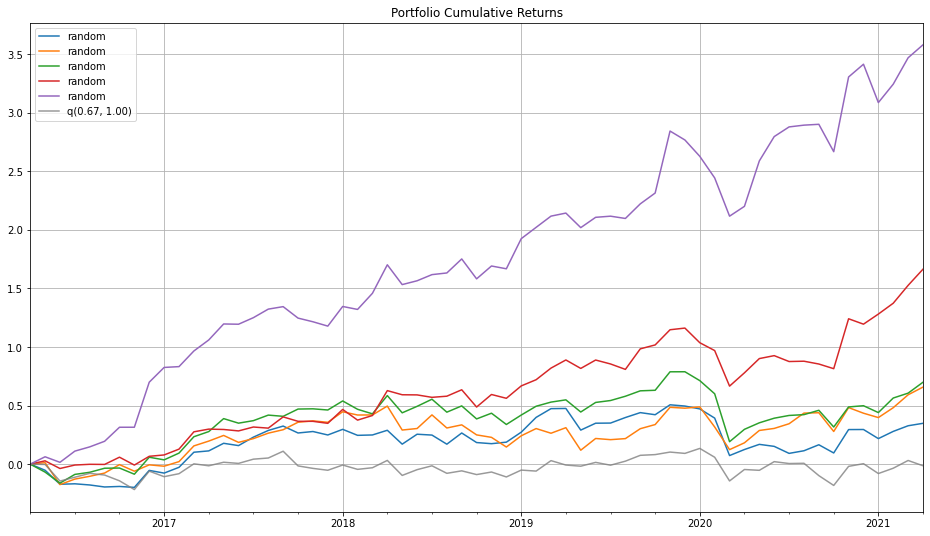

In [19]:
pqr.plot_cumulative_returns(results.values(), benchmark=best_portfolio)